# RAG Tutorial: Retrieval-Augmented Generation with Local Tools

This notebook demonstrates how to build a complete RAG (Retrieval-Augmented Generation) system using:
- **PostgreSQL** with pgvector extension for vector storage
- **Ollama** for local LLM and embedding models
- **Python** for the complete pipeline

## What is RAG?

RAG combines the power of:
1. **Retrieval**: Finding relevant information from a knowledge base
2. **Augmentation**: Using that information to enhance a query
3. **Generation**: Creating a response using a language model

This approach allows LLMs to access up-to-date, domain-specific information that wasn't in their training data.


## Setup and Imports

First, let's import all the necessary libraries:


In [7]:
import os
import psycopg
import ollama
import time
import json
from typing import List, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown


## Configuration

Set up the configuration for our RAG system:


In [ ]:
# Database configuration
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "rag_db"
DB_USER = "rag_user"
DB_PASSWORD = "password"

# Ollama configuration
OLLAMA_HOST = "http://localhost:11434"
GENERATION_MODEL = "gemma3:270m"  # You can change this to mistral:latest, llama3.2:1B, etc.
EMBEDDING_MODEL = "nomic-embed-text"
VECTOR_DIMENSION = 768  # nomic-embed-text model dimension

print(f"Using generation model: {GENERATION_MODEL}")
print(f"Using embedding model: {EMBEDDING_MODEL}")
print(f"Vector dimension: {VECTOR_DIMENSION}")


Using generation model: gemma3:270m
Using embedding model: nomic-embed-text
Vector dimension: 768


## Step 1: Database Connection and Setup

Let's connect to PostgreSQL and set up our database table:


In [9]:
def setup_database():
    """
    Connects to PostgreSQL database, creates the vector extension,
    and sets up the 'documents' table if it doesn't exist.
    """
    print("🔌 Connecting to PostgreSQL database...")
    
    try:
        conn = psycopg.connect(
            host=DB_HOST,
            port=DB_PORT,
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            autocommit=True,
            gssencmode="disable"
        )
        print("✅ Connection successful!")
        
        with conn.cursor() as cur:
            # Check if the 'vector' extension is installed
            cur.execute("SELECT 1 FROM pg_extension WHERE extname = 'vector';")
            if cur.fetchone() is None:
                print("❌ pgvector extension not found. Please install it first.")
                return None
            else:
                print("✅ pgvector extension is installed.")

            # Drop the table if it already exists to start fresh
            cur.execute("DROP TABLE IF EXISTS documents;")
            
            # Create the documents table with a vector column
            cur.execute(f"""
                CREATE TABLE documents (
                    id SERIAL PRIMARY KEY,
                    content TEXT,
                    embedding VECTOR({VECTOR_DIMENSION})
                );
            """)
            print(f"✅ Table 'documents' created successfully with VECTOR({VECTOR_DIMENSION}) column.")
        
        return conn

    except psycopg.OperationalError as e:
        print(f"❌ Could not connect to PostgreSQL: {e}")
        return None

# Test the database connection
conn = setup_database()


🔌 Connecting to PostgreSQL database...
✅ Connection successful!
✅ pgvector extension is installed.
✅ Table 'documents' created successfully with VECTOR(768) column.


## Step 2: Document Processing and Embedding Generation

Now let's process some sample documents and generate embeddings:


In [10]:
def process_documents(conn, documents: List[str]) -> bool:
    """
    Process documents, generate embeddings, and store them in the database.
    """
    print("📄 Processing documents and generating embeddings...")
    
    # Create the Ollama client
    client = ollama.Client(host=OLLAMA_HOST)
    
    results = []
    
    with conn.cursor() as cur:
        for i, doc in enumerate(documents):
            print(f"Processing document {i+1}/{len(documents)}: '{doc[:50]}...'")
            
            try:
                # Generate embedding for the document
                embedding_response = client.embeddings(
                    model=EMBEDDING_MODEL,
                    prompt=doc
                )
                embedding = embedding_response['embedding']
                
                # Insert the document and its embedding into the database
                cur.execute(
                    "INSERT INTO documents (content, embedding) VALUES (%s, %s);",
                    (doc, embedding)
                )
                
                results.append({
                    'document': doc,
                    'embedding_dim': len(embedding),
                    'embedding_preview': embedding[:5]  # First 5 dimensions
                })
                
                print(f"✅ Inserted document {i+1}. Vector dimension: {len(embedding)}")
                
            except Exception as e:
                print(f"❌ Error processing document {i+1}: {e}")
                return False
    
    print(f"✅ Successfully processed {len(documents)} documents.")
    return True, results

# Sample documents about llamas
sample_documents = [
    "A llama is a domesticated South American camelid, widely used as a meat and pack animal by Andean cultures since the pre-Columbian era.",
    "Llamas are social animals and live in herds. The largest are the guanacos, which can weigh up to 300 pounds.",
    "Llamas can be quite calm and cooperative if they are raised correctly, which makes them great companions for people in the mountains.",
    "A female llama gives birth standing up. The gestation period for a llama is about 11.5 months.",
    "The llamas have long, thick necks, a small head with a cleft upper lip, and long ears.",
    "Llamas are very intelligent and can learn simple tasks after a few repetitions.",
    "When overloaded or mistreated, llamas will lie down or refuse to move, and may spit, hiss, or even kick at their handlers.",
    "Llamas are used as pack animals and can carry 25-30% of their body weight for 8-13 km (5-8 miles)."
]

# Process the documents
success, results = process_documents(conn, sample_documents)

if success:
    # Display results in a nice table
    df = pd.DataFrame(results)
    display(df)


📄 Processing documents and generating embeddings...
Processing document 1/8: 'A llama is a domesticated South American camelid, ...'
✅ Inserted document 1. Vector dimension: 768
Processing document 2/8: 'Llamas are social animals and live in herds. The l...'
✅ Inserted document 2. Vector dimension: 768
Processing document 3/8: 'Llamas can be quite calm and cooperative if they a...'
✅ Inserted document 3. Vector dimension: 768
Processing document 4/8: 'A female llama gives birth standing up. The gestat...'
✅ Inserted document 4. Vector dimension: 768
Processing document 5/8: 'The llamas have long, thick necks, a small head wi...'
✅ Inserted document 5. Vector dimension: 768
Processing document 6/8: 'Llamas are very intelligent and can learn simple t...'
✅ Inserted document 6. Vector dimension: 768
Processing document 7/8: 'When overloaded or mistreated, llamas will lie dow...'
✅ Inserted document 7. Vector dimension: 768
Processing document 8/8: 'Llamas are used as pack animals and can 

,document,embedding_dim,embedding_preview
0,A llama is a domesticated South American camel...,768,"[0.5924586653709412, 0.8358101844787598, -3.40..."
1,Llamas are social animals and live in herds. T...,768,"[0.18468794226646423, 1.680791974067688, -3.29..."
2,Llamas can be quite calm and cooperative if th...,768,"[0.07570275664329529, 0.36676260828971863, -4...."
3,A female llama gives birth standing up. The ge...,768,"[1.3883503675460815, 0.9311917424201965, -3.65..."
4,"The llamas have long, thick necks, a small hea...",768,"[0.1881728172302246, 0.5021412968635559, -3.43..."
5,Llamas are very intelligent and can learn simp...,768,"[-0.20554983615875244, 0.8305619955062866, -4...."
6,"When overloaded or mistreated, llamas will lie...",768,"[0.8766179084777832, 0.6104104518890381, -3.86..."
7,Llamas are used as pack animals and can carry ...,768,"[-0.08904056996107101, 0.7915618419647217, -4...."


## Step 3: Vector Similarity Search

Let's implement the retrieval part of RAG - finding the most relevant documents:


🔍 Retrieving top 3 most relevant documents for: 'What makes a llama a good companion?'
✅ Retrieved 3 relevant documents

📋 Retrieved Documents:

1. Distance: 0.1745
   Content: Llamas can be quite calm and cooperative if they are raised correctly, which makes them great companions for people in the mountains.

2. Distance: 0.1971
   Content: A llama is a domesticated South American camelid, widely used as a meat and pack animal by Andean cultures since the pre-Columbian era.

3. Distance: 0.2006
   Content: Llamas are very intelligent and can learn simple tasks after a few repetitions.


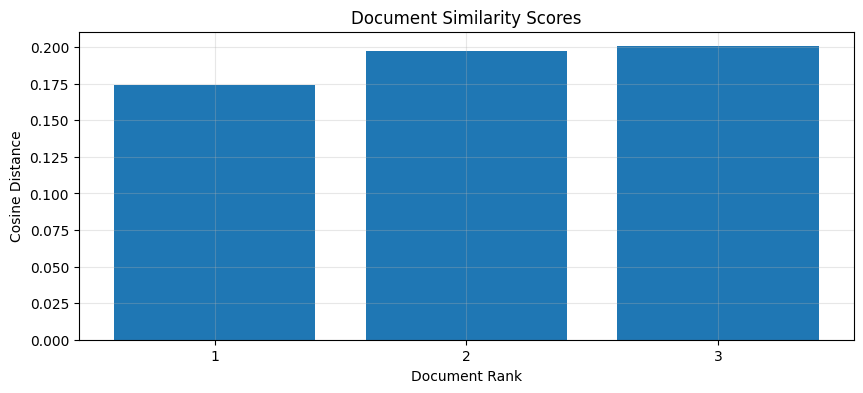

In [11]:
def retrieve_relevant_documents(conn, query: str, top_k: int = 3) -> List[Dict[str, Any]]:
    """
    Retrieve the most relevant documents for a given query using vector similarity.
    """
    print(f"🔍 Retrieving top {top_k} most relevant documents for: '{query}'")
    
    client = ollama.Client(host=OLLAMA_HOST)
    
    try:
        # Generate embedding for the query
        query_embedding_response = client.embeddings(
            model=EMBEDDING_MODEL,
            prompt=query
        )
        query_embedding = query_embedding_response['embedding']
        
        # Convert the embedding list to a PostgreSQL vector string
        vector_str = '[' + ','.join(map(str, query_embedding)) + ']'
        
        # Query the database for the most similar documents
        with conn.cursor() as cur:
            cur.execute(f"""
                SELECT
                    id,
                    content,
                    embedding <=> %s::vector as distance
                FROM
                    documents
                ORDER BY
                    embedding <=> %s::vector
                LIMIT %s;
            """, (vector_str, vector_str, top_k))
            
            results = []
            for row in cur.fetchall():
                results.append({
                    'id': row[0],
                    'content': row[1],
                    'distance': row[2]
                })
        
        print(f"✅ Retrieved {len(results)} relevant documents")
        return results
        
    except Exception as e:
        print(f"❌ Error during retrieval: {e}")
        return []

# Test retrieval with a sample query
query = "What makes a llama a good companion?"
relevant_docs = retrieve_relevant_documents(conn, query, top_k=3)

# Display the results
print("\n📋 Retrieved Documents:")
for i, doc in enumerate(relevant_docs, 1):
    print(f"\n{i}. Distance: {doc['distance']:.4f}")
    print(f"   Content: {doc['content']}")

# Create a visualization of the distances
if relevant_docs:
    distances = [doc['distance'] for doc in relevant_docs]
    plt.figure(figsize=(10, 4))
    plt.bar(range(1, len(distances) + 1), distances)
    plt.xlabel('Document Rank')
    plt.ylabel('Cosine Distance')
    plt.title('Document Similarity Scores')
    plt.xticks(range(1, len(distances) + 1))
    plt.grid(True, alpha=0.3)
    plt.show()


## Step 4: Response Generation

Now let's generate a response using the retrieved documents:


In [12]:
def generate_response(conn, query: str, top_k: int = 3) -> str:
    """
    Complete RAG pipeline: retrieve relevant documents and generate a response.
    """
    print(f"🤖 Generating response for: '{query}'")
    
    # Step 1: Retrieve relevant documents
    relevant_docs = retrieve_relevant_documents(conn, query, top_k)
    
    if not relevant_docs:
        return "Sorry, I couldn't find any relevant information."
    
    # Step 2: Create context from retrieved documents
    context = " ".join([doc['content'] for doc in relevant_docs])
    
    # Step 3: Construct the prompt
    prompt = f"""Based on the provided context, answer the question clearly and helpfully. Use only information from the context.

Context: {context}

Question: {query}

Answer:"""
    
    # Step 4: Generate response using the LLM
    client = ollama.Client(host=OLLAMA_HOST)
    
    try:
        print(f"\n📝 Retrieved context:")
        for i, doc in enumerate(relevant_docs, 1):
            print(f"{i}. {doc['content']}")
        
        print(f"\n🤖 Generating response with {GENERATION_MODEL}...")
        
        stream = client.generate(
            model=GENERATION_MODEL,
            prompt=prompt,
            stream=True
        )
        
        response = ""
        print("\n💬 Response:")
        for chunk in stream:
            response_text = chunk['response']
            response += response_text
            print(response_text, end='', flush=True)
        
        print("\n\n✅ RAG process complete!")
        return response
        
    except Exception as e:
        print(f"❌ Error generating response: {e}")
        return "Sorry, I encountered an error while generating the response."

# Test the complete RAG pipeline
test_queries = [
    "What makes a llama a good companion?",
    "How long is a llama's gestation period?",
    "What are llamas used for?",
    "How much weight can a llama carry?"
]

for query in test_queries:
    print("\n" + "="*80)
    print(f"QUERY: {query}")
    print("="*80)
    response = generate_response(conn, query)
    print("\n" + "-"*80)



QUERY: What makes a llama a good companion?
🤖 Generating response for: 'What makes a llama a good companion?'
🔍 Retrieving top 3 most relevant documents for: 'What makes a llama a good companion?'
✅ Retrieved 3 relevant documents

📝 Retrieved context:
1. Llamas can be quite calm and cooperative if they are raised correctly, which makes them great companions for people in the mountains.
2. A llama is a domesticated South American camelid, widely used as a meat and pack animal by Andean cultures since the pre-Columbian era.
3. Llamas are very intelligent and can learn simple tasks after a few repetitions.

🤖 Generating response with gemma3:270m...

💬 Response:
A llama is a domesticated South American camelid, widely used as a meat and pack animal by Andean cultures since the pre-Columbian era.

✅ RAG process complete!

--------------------------------------------------------------------------------

QUERY: How long is a llama's gestation period?
🤖 Generating response for: 'How long is a

## Step 5: Interactive RAG System

Let's create an interactive function for testing different queries:


In [13]:
def interactive_rag(conn):
    """
    Interactive RAG system for testing different queries.
    """
    print("🎯 Interactive RAG System")
    print("Type 'quit' to exit\n")
    
    while True:
        query = input("Ask a question about llamas: ")
        
        if query.lower() in ['quit', 'exit', 'q']:
            print("Goodbye! 👋")
            break
        
        if query.strip():
            print("\n" + "="*60)
            response = generate_response(conn, query)
            print("\n" + "="*60 + "\n")

# Uncomment the line below to start the interactive session
# interactive_rag(conn)


## Step 6: Analysis and Visualization

Let's analyze our RAG system's performance:


📊 RAG System Analysis
📄 Total documents: 8
📏 Average document length: 106.9 characters


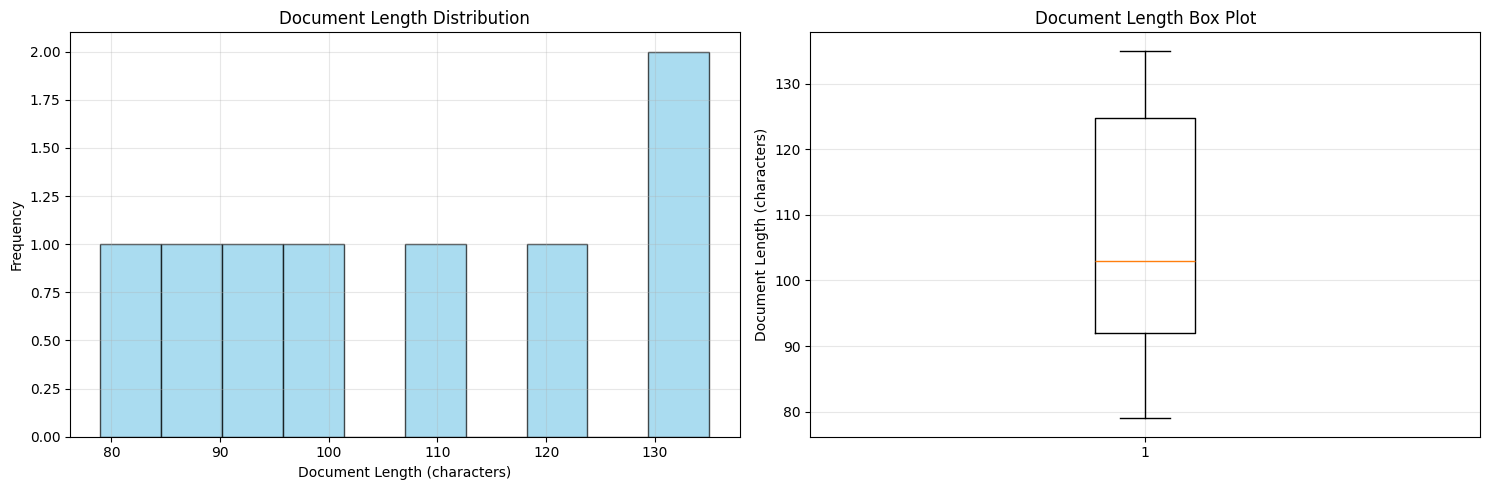


📋 Sample Documents:

1. ID: 1
   Content: A llama is a domesticated South American camelid, widely used as a meat and pack animal by Andean cu...

2. ID: 2
   Content: Llamas are social animals and live in herds. The largest are the guanacos, which can weigh up to 300...

3. ID: 3
   Content: Llamas can be quite calm and cooperative if they are raised correctly, which makes them great compan...


In [14]:
def analyze_rag_system(conn):
    """
    Analyze the RAG system's database and performance.
    """
    print("📊 RAG System Analysis")
    print("="*50)
    
    with conn.cursor() as cur:
        # Get document count
        cur.execute("SELECT COUNT(*) FROM documents;")
        doc_count = cur.fetchone()[0]
        print(f"📄 Total documents: {doc_count}")
        
        # Get average document length
        cur.execute("SELECT AVG(LENGTH(content)) FROM documents;")
        avg_length = cur.fetchone()[0]
        print(f"📏 Average document length: {avg_length:.1f} characters")
        
        # Get document length distribution
        cur.execute("SELECT LENGTH(content) as length FROM documents ORDER BY length;")
        lengths = [row[0] for row in cur.fetchall()]
        
        # Create visualizations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Document length distribution
        ax1.hist(lengths, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Document Length (characters)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Document Length Distribution')
        ax1.grid(True, alpha=0.3)
        
        # Document length box plot
        ax2.boxplot(lengths, vert=True)
        ax2.set_ylabel('Document Length (characters)')
        ax2.set_title('Document Length Box Plot')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Show sample documents
        cur.execute("SELECT id, content FROM documents LIMIT 3;")
        sample_docs = cur.fetchall()
        
        print("\n📋 Sample Documents:")
        for i, (doc_id, content) in enumerate(sample_docs, 1):
            print(f"\n{i}. ID: {doc_id}")
            print(f"   Content: {content[:100]}...")

# Run the analysis
analyze_rag_system(conn)


## Step 7: Cleanup

Finally, let's clean up our resources:


In [15]:
def cleanup(conn):
    """
    Clean up database resources.
    """
    if conn:
        conn.close()
        print("✅ Database connection closed.")

# Uncomment to clean up
# cleanup(conn)


## Summary

This notebook demonstrated a complete RAG system with:

1. **Document Processing**: Converting text into vector embeddings
2. **Vector Storage**: Using PostgreSQL with pgvector for efficient similarity search
3. **Retrieval**: Finding the most relevant documents for a query
4. **Generation**: Using a local LLM to create responses based on retrieved context
5. **Analysis**: Understanding system performance and document characteristics

### Key Benefits of RAG:
- **Up-to-date information**: Can access recent or domain-specific data
- **Reduced hallucination**: Grounded in retrieved facts
- **Scalable**: Can handle large knowledge bases
- **Local deployment**: Everything runs on your machine

### Next Steps:
- Try different models (mistral:latest, llama3.2:1B, etc.)
- Experiment with different embedding models
- Add more documents to the knowledge base
- Implement chunking strategies for longer documents
- Add metadata filtering for more precise retrieval
